## 1. Setup and Imports

In [1]:
!git clone https://github.com/ml-arena/permuted_mnist.git



Cloning into 'permuted_mnist'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 194 (delta 77), reused 163 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (194/194), 12.62 MiB | 4.81 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Updating files: 100% (21/21), done.


In [2]:
import sys
sys.path.append('/content/permuted_mnist')



In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Dict, List

# Import the environment and agents
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
from permuted_mnist.agent.random.agent import Agent as RandomAgent
from permuted_mnist.agent.linear.agent import Agent as LinearAgent
from permuted_mnist.agent.torch_mlp.agent import Agent as TorchMLP

print("✓ Imports successful")

✓ Imports successful


## 2. Create the Environment

Let's create an environment with 10 different permuted tasks:

In [4]:
# Create environment with 10 episodes (tasks)
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(42)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


## 3. Understanding the Task Structure

Let's examine what a single task looks like:

In [5]:
# Get the first task
task = env.get_next_task()

print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6131 samples
  Label 1: 6742 samples
  Label 2: 5421 samples
  Label 3: 5851 samples
  Label 4: 6265 samples
  Label 5: 5958 samples
  Label 6: 5949 samples
  Label 7: 5842 samples
  Label 8: 5923 samples
  Label 9: 5918 samples


## 4. Visualize Permuted Images

Let's see how the permutation affects the images:

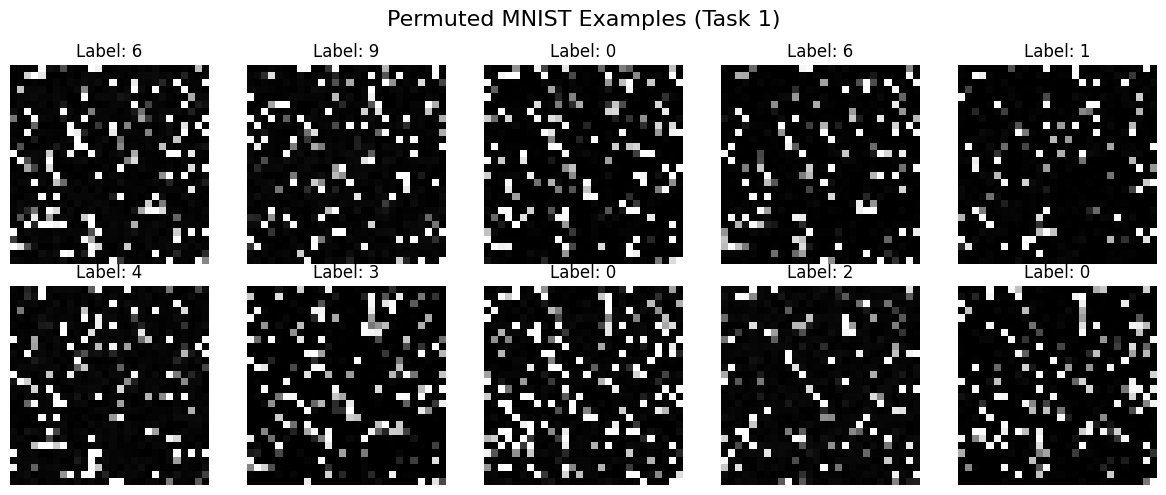

Note: The images look scrambled due to pixel permutation!
The labels are also permuted (not the original MNIST labels).


In [6]:
# Display some examples from the permuted task
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Permuted MNIST Examples (Task 1)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(task['X_train'][i], cmap='gray')
    ax.set_title(f'Label: {task["y_train"][i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: The images look scrambled due to pixel permutation!")
print("The labels are also permuted (not the original MNIST labels).")

## 5. Baseline: Random Agent

First, let's establish a baseline with an agent that makes random predictions:
这个智能体（RandomAgent）什么也不会学，只是：

收到训练数据后，什么也不做；

在预测时，随机输出 0–9 之间的数字；

用这个结果去计算准确率。

In [7]:
# Reset environment for fresh start
env.reset()
env.set_seed(42)

# Create random agent
random_agent = RandomAgent(output_dim=10, seed=42)

# Track performance
random_accuracies = []
random_times = []

print("Evaluating Random Agent (Baseline)")
print("="*50)

# Evaluate on all tasks
task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    start_time = time.time()

    # "Train" (random agent doesn't actually learn)
    random_agent.train(task['X_train'], task['y_train'])

    # Make predictions
    predictions = random_agent.predict(task['X_test'])

    # Calculate time and accuracy
    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])

    random_accuracies.append(accuracy)
    random_times.append(elapsed_time)

    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
    task_num += 1

print(f"\nRandom Agent Summary:")
print(f"  Mean accuracy: {np.mean(random_accuracies):.2%} ± {np.std(random_accuracies):.2%}")
print(f"  Total time: {np.sum(random_times):.2f}s")

Evaluating Random Agent (Baseline)
Task 1: Accuracy = 9.96%, Time = 0.0003s
Task 2: Accuracy = 9.70%, Time = 0.0003s
Task 3: Accuracy = 10.41%, Time = 0.0003s
Task 4: Accuracy = 10.02%, Time = 0.0003s
Task 5: Accuracy = 10.23%, Time = 0.0004s
Task 6: Accuracy = 9.94%, Time = 0.0003s
Task 7: Accuracy = 10.29%, Time = 0.0003s
Task 8: Accuracy = 10.27%, Time = 0.0003s
Task 9: Accuracy = 9.93%, Time = 0.0003s
Task 10: Accuracy = 10.09%, Time = 0.0003s

Random Agent Summary:
  Mean accuracy: 10.08% ± 0.20%
  Total time: 0.00s


## 6. Linear Agent

Now let's train a simple linear classifier that actually learns from the data:

In [8]:
# Reset environment
env.reset()
env.set_seed(42)

# Create linear agent
linear_agent = LinearAgent(input_dim=784, output_dim=10, learning_rate=0.01)

# Track performance
linear_accuracies = []
linear_times = []

print("Evaluating Linear Agent")
print("="*50)

# Evaluate on all tasks
task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    # Reset agent for new task
    linear_agent.reset()

    start_time = time.time()

    # Train the linear model
    linear_agent.train(task['X_train'], task['y_train'], epochs=5, batch_size=32)

    # Make predictions
    predictions = linear_agent.predict(task['X_test'])

    # Calculate time and accuracy
    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])

    linear_accuracies.append(accuracy)
    linear_times.append(elapsed_time)

    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.2f}s")
    task_num += 1

print(f"\nLinear Agent Summary:")
print(f"  Mean accuracy: {np.mean(linear_accuracies):.2%} ± {np.std(linear_accuracies):.2%}")
print(f"  Total time: {np.sum(linear_times):.2f}s")

Evaluating Linear Agent
Task 1: Accuracy = 90.87%, Time = 2.45s
Task 2: Accuracy = 90.87%, Time = 2.42s
Task 3: Accuracy = 90.72%, Time = 2.41s
Task 4: Accuracy = 90.90%, Time = 2.38s
Task 5: Accuracy = 90.70%, Time = 2.42s
Task 6: Accuracy = 90.77%, Time = 2.43s
Task 7: Accuracy = 90.79%, Time = 4.33s
Task 8: Accuracy = 90.79%, Time = 3.45s
Task 9: Accuracy = 90.83%, Time = 2.41s
Task 10: Accuracy = 90.82%, Time = 2.38s

Linear Agent Summary:
  Mean accuracy: 90.81% ± 0.06%
  Total time: 27.09s


After the exploration of data,we can now evaluatino our model.
This time ,we want to build a deep model that can truly learn nonlinear structures.
Compared to the previous linear classifier, this model:

Has at least one hidden layer (for example: 784 → 256 → 10);

Uses activation functions (ReLU, Tanh, etc.) to introduce nonlinearity;

Is retrained and makes predictions on each permuted task.

In [9]:
# Reset environment
env.reset()
env.set_seed(42)

# Create linear agent
torchmlp = TorchMLP(output_dim=10,seed=42)

# Track performance
torchmlp_accuracies = []
torchmlp_times = []

print("Evaluating TorchMLP Agent")
print("="*50)

# Evaluate on all tasks
task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    # Reset agent for new task
    torchmlp.reset()

    start_time = time.time()

    # Train the linear model
    torchmlp.train(task['X_train'], task['y_train'])

    # Make predictions
    predictions = torchmlp.predict(task['X_test'])

    # Calculate time and accuracy
    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])

    torchmlp_accuracies.append(accuracy)
    torchmlp_times.append(elapsed_time)

    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(torchmlp_accuracies):.2%} ± {np.std(torchmlp_accuracies):.2%}")
print(f"  Total time: {np.sum(torchmlp_times):.2f}s")

Evaluating TorchMLP Agent
epoch 0: 0.9623%
epoch 1: 0.9715%
epoch 2: 0.9735%
epoch 3: 0.9763%
epoch 4: 0.9776%
epoch 5: 0.9781%
epoch 6: 0.9812%
epoch 7: 0.9777%
epoch 8: 0.9816%
epoch 9: 0.9832%
Task 1: Accuracy = 98.02%, Time = 191.50s
epoch 0: 0.9636%
epoch 1: 0.9732%
epoch 2: 0.9742%
epoch 3: 0.9779%
epoch 4: 0.9813%
epoch 5: 0.9793%
epoch 6: 0.9802%
epoch 7: 0.9817%
epoch 8: 0.9801%
epoch 9: 0.9817%
Task 2: Accuracy = 98.18%, Time = 161.67s
epoch 0: 0.9665%
epoch 1: 0.9719%
epoch 2: 0.9732%
epoch 3: 0.9742%
epoch 4: 0.9782%
epoch 5: 0.9769%
epoch 6: 0.9764%
epoch 7: 0.9810%
epoch 8: 0.9779%
epoch 9: 0.9811%
Task 3: Accuracy = 98.05%, Time = 161.01s
epoch 0: 0.9617%
epoch 1: 0.9732%
epoch 2: 0.9751%
epoch 3: 0.9774%
epoch 4: 0.9782%
epoch 5: 0.9773%
epoch 6: 0.9821%
epoch 7: 0.9829%
epoch 8: 0.9834%
epoch 9: 0.9806%
Task 4: Accuracy = 98.07%, Time = 158.19s
epoch 0: 0.9576%
epoch 1: 0.9756%
epoch 2: 0.9762%
epoch 3: 0.9770%
epoch 4: 0.9807%
epoch 5: 0.9776%
epoch 6: 0.9808%
epoch 7

We try to explore how the change of hyperameter influence the accuracy and time.

In [10]:
# ===== TorchMLP (speed profile with early stopping) =====
import time, math, numpy as np
import torch, torch.nn as nn, torch.optim as optim

try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _flatten_np(X):
    return X.reshape(X.shape[0], -1).astype(np.float32, copy=False)

def _labels_1d(y):
    y = np.asarray(y)
    return y.reshape(-1).astype(np.int64, copy=False)

@torch.no_grad()
def _scalar_norm_fit(X):
    m = float(X.mean()); s = float(X.std())
    if s < 1e-6: s = 1.0
    return m, s

class _SpeedMLP(nn.Module):
    def __init__(self, in_dim=784, h1=512, h2=256, out_dim=10, p=0.10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.ReLU(), nn.Dropout(p),
            nn.Linear(h1, h2),     nn.ReLU(), nn.Dropout(p),
            nn.Linear(h2, out_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x): return self.net(x)

class TorchMLP:
    def __init__(self, output_dim=10, seed=42,
                 time_budget=5.5, subsample_n=20000,
                 val_ratio=0.1, batch_size=2048,
                 lr=3e-3, weight_decay=1e-4,
                 patience=2, min_delta=0.001, min_train_seconds=2.5):
        self.output_dim = output_dim
        self.seed = seed
        self.time_budget = float(time_budget)
        self.subsample_n = int(subsample_n)
        self.val_ratio = float(val_ratio)
        self.batch_size = int(batch_size)
        self.lr = float(lr)
        self.weight_decay = float(weight_decay)
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.min_train_seconds = float(min_train_seconds)
        self.device = torch.device("cpu")
        self.model = None
        self.mean_, self.std_ = 0.0, 1.0
        self.reset()

    def reset(self):
        np.random.seed(self.seed); torch.manual_seed(self.seed)
        self.model = _SpeedMLP(out_dim=self.output_dim).to(self.device)
        self.mean_, self.std_ = 0.0, 1.0

    def _make_loader(self, X, y, bs, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=shuffle,
                                           drop_last=False, num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        t0 = time.time()
        Xf = _flatten_np(X_train)
        y = _labels_1d(y_train)
        N = Xf.shape[0]
        ss = min(self.subsample_n, N)
        idx = np.random.default_rng(self.seed).choice(N, ss, replace=False)
        Xs = torch.from_numpy(Xf[idx]).float().to(self.device)
        ys = torch.from_numpy(y[idx]).to(self.device)

        n_val = max(1000, int(len(Xs) * 0.1))
        n_tr  = len(Xs) - n_val
        X_tr, X_val = Xs[:n_tr], Xs[n_tr:]
        y_tr, y_val = ys[:n_tr], ys[n_tr:]

        self.mean_, self.std_ = _scalar_norm_fit(X_tr)
        X_tr = (X_tr - self.mean_) / self.std_
        X_val = (X_val - self.mean_) / self.std_

        opt = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()
        loader = self._make_loader(X_tr, y_tr, self.batch_size, shuffle=True)

        best_acc, no_improve = 0.0, 0
        self.model.train()
        while True:
            for xb, yb in loader:
                if time.time() - t0 > self.time_budget: break
                opt.zero_grad(set_to_none=True)
                loss = crit(self.model(xb), yb)
                loss.backward(); opt.step()
            if time.time() - t0 > self.time_budget: break

            # 验证
            with torch.no_grad():
                self.model.eval()
                bs_eval = 8192
                correct, total = 0, 0
                for i in range(0, X_val.shape[0], bs_eval):
                    logits = self.model(X_val[i:i+bs_eval])
                    pred = logits.argmax(dim=1)
                    correct += (pred == y_val[i:i+bs_eval]).sum().item()
                    total   += min(bs_eval, X_val.shape[0]-i)
                val_acc = correct / max(1, total)
                self.model.train()

            if val_acc > best_acc + self.min_delta:
                best_acc = val_acc
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= self.patience and (time.time()-t0) >= self.min_train_seconds:
                break

    @torch.no_grad()
    def predict(self, X_test):
        X = torch.from_numpy(_flatten_np(X_test)).float().to(self.device)
        X = (X - self.mean_) / self.std_
        self.model.eval()
        bs = 8192
        out = []
        for i in range(0, X.shape[0], bs):
            out.append(torch.argmax(self.model(X[i:i+bs]), dim=1).cpu().numpy())
        return np.concatenate(out, axis=0)
# Reset environment
env.reset()
env.set_seed(42)

# Create agent
torchmlp = TorchMLP(output_dim=10, seed=42)

# Track performance
accs, times = [], []

print("Evaluating TorchMLP Agent")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    torchmlp.reset()
    start = time.time()
    torchmlp.train(task['X_train'], task['y_train'])
    preds = torchmlp.predict(task['X_test'])
    elapsed = time.time() - start
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent
Task 1: Accuracy = 94.36%, Time = 5.79s
Task 2: Accuracy = 94.43%, Time = 6.01s
Task 3: Accuracy = 94.16%, Time = 5.86s
Task 4: Accuracy = 93.52%, Time = 5.78s
Task 5: Accuracy = 94.90%, Time = 5.71s
Task 6: Accuracy = 95.97%, Time = 5.79s
Task 7: Accuracy = 94.97%, Time = 5.73s
Task 8: Accuracy = 94.25%, Time = 5.96s
Task 9: Accuracy = 92.52%, Time = 5.86s
Task 10: Accuracy = 93.89%, Time = 6.45s

TorchMLP Agent Summary:
  Mean accuracy: 94.30% ± 0.87%
  Total time: 58.93s


There we use Optimizer Adam to improve our accuracy.

In [11]:
# ===== TorchMLP-BN (2x100, BN, ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2) =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

class _MLP_BN(nn.Module):
    """784 -> 100 -> 100 -> 10 with BatchNorm + ReLU"""
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim),
        )
        # 轻量初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)

        self.model = None
        self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)


        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)
# ===== Evaluate TorchMLP-BN (fixed) =====
import time, numpy as np

env.reset()
env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (BN, 2x100)")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 2x100)
Task 1: Accuracy = 97.26%, Time = 6.02s
Task 2: Accuracy = 97.25%, Time = 5.90s
Task 3: Accuracy = 97.25%, Time = 6.01s
Task 4: Accuracy = 97.19%, Time = 6.58s
Task 5: Accuracy = 96.93%, Time = 6.61s
Task 6: Accuracy = 97.50%, Time = 8.14s
Task 7: Accuracy = 97.10%, Time = 9.42s
Task 8: Accuracy = 97.35%, Time = 8.34s
Task 9: Accuracy = 97.31%, Time = 7.58s
Task 10: Accuracy = 97.15%, Time = 9.53s

TorchMLP Agent Summary:
  Mean accuracy: 97.23% ± 0.15%
  Total time: 74.13s


We add L2 Normalization in the previous model

In [12]:
# ===== TorchMLP-BN (2x100, BN, ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """784 -> 100 -> 100 -> 10 with BatchNorm + ReLU"""
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm + FE：
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (BN, 2x100) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 2x100) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.41%, Time = 10.29s
Task 2: Accuracy = 97.34%, Time = 8.98s
Task 3: Accuracy = 97.35%, Time = 10.70s
Task 4: Accuracy = 97.46%, Time = 6.49s
Task 5: Accuracy = 97.15%, Time = 7.00s
Task 6: Accuracy = 97.37%, Time = 7.06s
Task 7: Accuracy = 97.15%, Time = 6.86s
Task 8: Accuracy = 97.27%, Time = 6.16s
Task 9: Accuracy = 97.33%, Time = 6.19s
Task 10: Accuracy = 97.33%, Time = 6.59s

TorchMLP Agent Summary:
  Mean accuracy: 97.32% ± 0.10%
  Total time: 76.32s


give a hiddensize a tapered width like pyramid!

In [13]:
# ===== TorchMLP-BN (256→128 pyramid, BN, ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """
    方案B：金字塔宽度 784 -> 256 -> 128 -> 10，层内 BN + ReLU；
    为了与外部调用保持完全兼容，保留参数签名(in_dim, h, out_dim)但忽略 h。
    隐藏层用 bias=False（配合BN），输出层 bias=True；Xavier 初始化，bias=0。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        h1, h2 = 256, 128
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1, bias=False),
            nn.BatchNorm1d(h1),
            nn.ReLU(inplace=True),

            nn.Linear(h1, h2, bias=False),
            nn.BatchNorm1d(h2),
            nn.ReLU(inplace=True),

            nn.Linear(h2, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 保持外部调用格式不变：仍然传 h=100；内部模型忽略 h，固定为 256→128
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-BN (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (BN, 256→128 pyramid) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 256→128 pyramid) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.59%, Time = 10.12s
Task 2: Accuracy = 97.38%, Time = 10.46s
Task 3: Accuracy = 97.57%, Time = 11.98s
Task 4: Accuracy = 97.58%, Time = 12.91s
Task 5: Accuracy = 97.43%, Time = 11.09s
Task 6: Accuracy = 97.66%, Time = 12.07s
Task 7: Accuracy = 97.49%, Time = 12.51s
Task 8: Accuracy = 97.59%, Time = 10.79s
Task 9: Accuracy = 97.59%, Time = 12.67s
Task 10: Accuracy = 97.69%, Time = 13.21s

TorchMLP Agent Summary:
  Mean accuracy: 97.56% ± 0.09%
  Total time: 117.81s


We try to replace ReLU in first layer with SiLU because it converge more quickly.

In [14]:
# ===== TorchMLP (首层 SiLU，其余 ReLU；Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """
    方案3：结构仍为 784 -> 100 -> 100 -> 10，层内 BN；
          首层激活使用 SiLU，第二层保持 ReLU。
    隐藏层 bias=False（配合BN），输出层 bias=True；Xavier 初始化 + bias=0。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h, bias=False),
            nn.BatchNorm1d(h),
            nn.SiLU(inplace=True),          # ← 首层激活换为 SiLU

            nn.Linear(h, h, bias=False),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),          # ← 第二层保持 ReLU

            nn.Linear(h, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 仍然以 h=100 调用，结构内部已按方案3定义
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP (SiLU first layer, ReLU second) with per-sample L2 FE =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (BN, 100→100; first SiLU then ReLU) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (BN, 100→100; first SiLU then ReLU) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.42%, Time = 6.87s
Task 2: Accuracy = 97.27%, Time = 8.36s
Task 3: Accuracy = 97.25%, Time = 9.66s
Task 4: Accuracy = 97.33%, Time = 9.60s
Task 5: Accuracy = 97.24%, Time = 6.81s
Task 6: Accuracy = 97.27%, Time = 8.53s
Task 7: Accuracy = 97.19%, Time = 6.82s
Task 8: Accuracy = 97.41%, Time = 6.36s
Task 9: Accuracy = 97.34%, Time = 6.06s
Task 10: Accuracy = 97.46%, Time = 5.83s

TorchMLP Agent Summary:
  Mean accuracy: 97.32% ± 0.08%
  Total time: 74.90s


We try to add one hidden layer to improve accuracy

In [15]:
# ===== TorchMLP-Deep (128-128-128; BN+ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2) + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """
    方案4：瘦而稍深 —— 784 -> 128 -> 128 -> 128 -> 10
    三个隐藏层均为 BN + ReLU；隐藏层 bias=False（配合BN），输出层 bias=True。
    保持与外部相同签名(in_dim, h, out_dim)，但内部固定为 128-128-128。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        d = 128
        self.net = nn.Sequential(
            nn.Linear(in_dim, d, bias=False), nn.BatchNorm1d(d), nn.ReLU(inplace=True),
            nn.Linear(d, d, bias=False),      nn.BatchNorm1d(d), nn.ReLU(inplace=True),
            nn.Linear(d, d, bias=False),      nn.BatchNorm1d(d), nn.ReLU(inplace=True),
            nn.Linear(d, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 保持外部调用格式不变：仍然传 h=100；内部固定为 128-128-128
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-Deep (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (Deep 128×3) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (Deep 128×3) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.62%, Time = 14.18s
Task 2: Accuracy = 97.50%, Time = 11.29s
Task 3: Accuracy = 97.34%, Time = 10.01s
Task 4: Accuracy = 97.33%, Time = 10.45s
Task 5: Accuracy = 97.33%, Time = 11.45s
Task 6: Accuracy = 97.29%, Time = 8.76s
Task 7: Accuracy = 97.37%, Time = 10.84s
Task 8: Accuracy = 97.73%, Time = 9.95s
Task 9: Accuracy = 97.41%, Time = 10.81s
Task 10: Accuracy = 97.48%, Time = 10.54s

TorchMLP Agent Summary:
  Mean accuracy: 97.44% ± 0.14%
  Total time: 108.28s


Add bottleneck to the medium layer

In [16]:
# ===== TorchMLP-BottleneckRes (784→256 → [Bottleneck 256→64→256] → 128 → 10; Adam lr=1e-3; bs=128; epochs=3; val=0.2)
# + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

# ===== 方案5：瓶颈残差（更省算力的残差块）=====
class _BottleneckBlock(nn.Module):
    """
    预激活瓶颈残差：
      BN → SiLU → Linear(d→b, bias=False)
      BN → SiLU → Linear(b→d, bias=False)
    其中 b << d（本实现 b=64, d=256），计算量更低，3个epoch内更易稳定提升。
    """
    def __init__(self, d: int, b: int):
        super().__init__()
        self.bn1  = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1  = nn.Linear(d, b, bias=False)

        self.bn2  = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2  = nn.Linear(b, d, bias=False)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_BN(nn.Module):
    """
    为与外部调用保持兼容，保留签名(in_dim, h, out_dim)但内部结构固定：
      784 → 256 → [Bottle(256→64→256) × 1] → 128 → 10
    隐藏层 bias=False（配合BN），输出层 bias=True；Xavier 初始化 + bias=0。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10, d1=256, bottleneck=64, d2=128):
        super().__init__()
        self.inp = nn.Linear(in_dim, d1, bias=False)
        self.in_bn = nn.BatchNorm1d(d1)
        self.in_act = nn.SiLU(inplace=True)

        self.block = _BottleneckBlock(d=d1, b=bottleneck)

        self.mid = nn.Sequential(
            nn.BatchNorm1d(d1),
            nn.ReLU(inplace=True),
            nn.Linear(d1, d2, bias=False),
            nn.BatchNorm1d(d2),
            nn.ReLU(inplace=True),
        )
        self.head = nn.Linear(d2, out_dim, bias=True)

        # 初始化
        nn.init.xavier_uniform_(self.inp.weight)
        nn.init.xavier_uniform_(self.head.weight)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        h = self.in_act(self.in_bn(self.inp(x)))
        h = self.block(h)
        h = self.mid(h)
        return self.head(h)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 仍然以 h=100 调用；内部固定为瓶颈残差结构
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-BottleneckRes (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (Bottleneck Residual 256→64→256, then 128) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (Bottleneck Residual 256→64→256, then 128) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.63%, Time = 11.61s
Task 2: Accuracy = 97.77%, Time = 11.58s
Task 3: Accuracy = 97.85%, Time = 14.31s
Task 4: Accuracy = 97.77%, Time = 16.63s
Task 5: Accuracy = 97.57%, Time = 14.10s
Task 6: Accuracy = 97.83%, Time = 11.81s
Task 7: Accuracy = 97.80%, Time = 11.57s
Task 8: Accuracy = 97.61%, Time = 11.49s
Task 9: Accuracy = 97.75%, Time = 11.31s
Task 10: Accuracy = 97.73%, Time = 17.71s

TorchMLP Agent Summary:
  Mean accuracy: 97.73% ± 0.09%
  Total time: 132.12s


try a new structre named DualPath

In [17]:
# ===== TorchMLP-DualPath (并联双路径：主干 256→128 + 线性快路 64；Concat→10; Adam lr=1e-3; bs=128; epochs=3; val=0.2)
# + FE: per-sample L2 normalization =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """
    对每一张图做 L2 归一化；返回与输入相同形状。
    只做输入侧FE，其他训练/结构/超参一律不变。
    """
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """
    方案6：并联“双路径”：一个主干非线性通道 + 一个浅层线性快路，最后拼接后分类。
      - 主干：784 → 256 → 128  （BN+ReLU）
      - 快路：784 → 64         （BN+ReLU）   —— 相当于给模型一条“近端”路径捕获线性/弱非线性
      - 融合：Concat(128, 64)=192 → 10
    隐藏层 bias=False（配合BN），输出层 bias=True；Xavier 初始化 + bias=0。
    """
    def __init__(self, in_dim=784, h=100, out_dim=10, d1=256, d2=128, d_skip=64):
        super().__init__()
        # 主干路径
        self.main = nn.Sequential(
            nn.Linear(in_dim, d1, bias=False), nn.BatchNorm1d(d1), nn.ReLU(inplace=True),
            nn.Linear(d1, d2,   bias=False),   nn.BatchNorm1d(d2), nn.ReLU(inplace=True),
        )
        # 线性快路（浅路径）
        self.skip = nn.Sequential(
            nn.Linear(in_dim, d_skip, bias=False), nn.BatchNorm1d(d_skip), nn.ReLU(inplace=True),
        )
        # 融合后的分类头
        self.head = nn.Linear(d2 + d_skip, out_dim, bias=True)

        # 初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        h_main = self.main(x)
        h_skip = self.skip(x)
        h = torch.cat([h_main, h_skip], dim=1)
        return self.head(h)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数完全不变） + FE：
      * 每张图做 L2 归一化；
      * 训练和预测都使用同样的 FE；
      * 其它超参/结构/循环不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)
        self.batch_size   = int(batch_size)
        self.lr           = float(lr)
        self.val_ratio    = float(val_ratio)
        self.weight_decay = float(weight_decay)
        self.device       = torch.device("cpu")

        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        # 保持外部调用签名一致（h=100）；内部采用双路径结构
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    # === 训练/预测逻辑保持不变，仅在输入端加入 per-sample L2 FE ===
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.arange(n_total)
        np.random.shuffle(idx)
        val_idx = idx[:n_val]
        tr_idx  = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # ---- FE: 每样本 L2 归一化（仅此改动）----
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for ep in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        # ---- FE: 同样做每样本 L2 归一化（仅此改动）----
        X = _l2_per_sample(X)
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate TorchMLP-DualPath (same params, per-sample L2 FE) =====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []

print("Evaluating TorchMLP Agent (DualPath: main 256→128 + skip 64, concat) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP Agent (DualPath: main 256→128 + skip 64, concat) with Per-Sample L2 Normalization
Task 1: Accuracy = 97.56%, Time = 10.19s
Task 2: Accuracy = 97.94%, Time = 10.05s
Task 3: Accuracy = 97.68%, Time = 14.54s
Task 4: Accuracy = 97.79%, Time = 12.05s
Task 5: Accuracy = 97.79%, Time = 16.65s
Task 6: Accuracy = 97.85%, Time = 15.88s
Task 7: Accuracy = 97.55%, Time = 10.07s
Task 8: Accuracy = 97.75%, Time = 14.94s
Task 9: Accuracy = 97.63%, Time = 16.56s
Task 10: Accuracy = 97.53%, Time = 9.98s

TorchMLP Agent Summary:
  Mean accuracy: 97.71% ± 0.13%
  Total time: 130.92s


we try to add optimizer in our code. Actually,we have tried Adam,RMSprop,SGD,but finally we show the test of RMSprop here because we find it both obtain best accuracy and take least time.

In [18]:
# ===== TorchMLP-RMSprop + Cosine (与两优化器脚本中 RMSprop 分支等价) =====
# 结构/超参/FE 均与原脚本一致：lr=1e-3, bs=128, epochs=3, val=0.2, per-sample L2
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)  # (N,28,28)->(N,784)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x
# ---------------------------------------------------------

# === 模型：金字塔 256→128（BN+ReLU），与对比脚本相同 ===
class _MLP_BN(nn.Module):
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        h1, h2 = 256, 128
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1, bias=False), nn.BatchNorm1d(h1), nn.ReLU(inplace=True),
            nn.Linear(h1, h2, bias=False),     nn.BatchNorm1d(h2), nn.ReLU(inplace=True),
            nn.Linear(h2, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim()==3: x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    固定 RMSprop（alpha=0.99, momentum=0.0, centered=False）+ 余弦退火（与对比脚本一致）
    其它保持：epochs=3, bs=128, lr=1e-3, val_ratio=0.2, FE=per-sample L2
    """
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0, use_cosine=True):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay
        self.use_cosine=use_cosine
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE：每样本 L2（训练/验证一致）
        X_tr = _l2_per_sample(X_tr); X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        # === RMSprop 与对比脚本一致 ===
        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs, eta_min=0.0) if self.use_cosine else None
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            if sch is not None: sch.step()

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test).to(self.device)
        X = _l2_per_sample(X)
        self.model.eval()
        bs=4096; outs=[]
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate: 单独 RMSprop（与对比脚本 RMSprop 分支完全一致）=====
import time, numpy as np

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2,
                 use_cosine=True)  # 与两优化器脚本里的 RMSprop=True 对齐

accs, times = [], []

print("Evaluating TorchMLP (RMSprop + Cosine, 256→128) with Per-Sample L2 Normalization")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None: break

    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


Evaluating TorchMLP (RMSprop + Cosine, 256→128) with Per-Sample L2 Normalization
Task 1: Accuracy = 98.05%, Time = 8.10s
Task 2: Accuracy = 98.11%, Time = 8.15s
Task 3: Accuracy = 97.94%, Time = 8.04s
Task 4: Accuracy = 98.03%, Time = 9.20s
Task 5: Accuracy = 98.15%, Time = 8.69s
Task 6: Accuracy = 98.08%, Time = 10.93s
Task 7: Accuracy = 98.05%, Time = 8.47s
Task 8: Accuracy = 97.92%, Time = 10.41s
Task 9: Accuracy = 98.06%, Time = 8.20s
Task 10: Accuracy = 98.09%, Time = 8.18s

TorchMLP Agent Summary:
  Mean accuracy: 98.05% ± 0.07%
  Total time: 88.36s


Hyperparameter Tuning for n_epochs = [5, 7, 10] and hidden_size   = [(256,128), (384,192)].Moreover to retraint time, we use compressed model like Dynamic INT8to disease time using.

In [ ]:
# ===== TorchMLP-RMSprop(+Cosine) + Dynamic INT8（仅推理） + 6组网格评测 =====
# 保持：FE=per-sample L2、RMSprop(alpha=0.99,momentum=0,centered=False)、Cosine LR、CE 损失、CPU 推理
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 评测约束：限制CPU线程
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ---------------- I/O 与 FE ----------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)  # (N,28,28)->(N,784)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x

# ---------------- 模型（隐藏层可参数化） ----------------
class _MLP_BN(nn.Module):
    """
    结构：784 -> h1 -> h2 -> 10，每层 BN+ReLU（输出层无 BN/激活）
    """
    def __init__(self, in_dim=784, h1=256, h2=128, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1, bias=False), nn.BatchNorm1d(h1), nn.ReLU(inplace=True),
            nn.Linear(h1, h2, bias=False),     nn.BatchNorm1d(h2), nn.ReLU(inplace=True),
            nn.Linear(h2, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim()==3: x = x.view(x.size(0), -1)
        return self.net(x)

# ---------------- Agent（新增 dynamic INT8 压缩器） ----------------
class TorchMLP:
    """
    固定：RMSprop(+Cosine)、CE、FE=L2、CPU
    仅新增：compress_dynamic_int8() —— 推理前对 Linear 做 dynamic quant(INT8)
    """
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0, use_cosine=True, h1=256, h2=128):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay
        self.use_cosine=use_cosine; self.h1=h1; self.h2=h2
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.model_int8=None
        self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h1=self.h1, h2=self.h2, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE
        X_tr = _l2_per_sample(X_tr); X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs, eta_min=0.0) if self.use_cosine else None
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            if sch is not None: sch.step()

    # ---- 动态 INT8 压缩（只量化 Linear，推理专用）----
    def compress_dynamic_int8(self):
        import torch.quantization as tq  # 与经典用法一致
        mdl = self.model.to("cpu").eval()
        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)          # CPU
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs=4096; outs=[]
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ---------------- 6 组网格评测：epochs×hidden ----------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

# 若已有 env，可沿用其 episode 数；否则默认 10
try:
    EPISODES = env.number_episodes
except Exception:
    EPISODES = 10

search_epochs = [5, 7, 10]
hidden_cfgs   = [(256,128), (384,192)]   # 两套隐藏层：常规模型 vs 更大容量

all_results = []
print("\n=== Grid Search (RMSprop + FE + Dynamic INT8 inference) ===")

for ep in search_epochs:
    for (h1, h2) in hidden_cfgs:
        # 为可比性，重建环境并固定随机种子
        e = PermutedMNISTEnv(number_episodes=EPISODES)
        e.set_seed(42)

        agent = TorchMLP(output_dim=10, seed=42,
                         epochs=ep, batch_size=128, lr=1e-3, val_ratio=0.2,
                         use_cosine=True, h1=h1, h2=h2)

        accs, times = [], []
        print(f"\n---- Config: epochs={ep}, hidden=({h1},{h2}), batch_size=128 ----")
        tid = 1
        while True:
            task = e.get_next_task()
            if task is None: break
            agent.reset()

            t0 = time.time()
            agent.train(task['X_train'], task['y_train'])

            # 仅在推理前做动态 INT8 压缩；其他完全不变
            agent.compress_dynamic_int8()

            preds   = agent.predict(task['X_test'])
            elapsed = time.time() - t0

            acc = e.evaluate(preds, task['y_test'])
            accs.append(acc); times.append(elapsed)
            print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
            tid += 1

        mean_acc = float(np.mean(accs))
        total_t  = float(np.sum(times))
        all_results.append((ep, h1, h2, mean_acc, total_t))
        print(f"** Summary -> Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s")

# 终汇总
print("\n===== Overall Summary (Dynamic INT8 inference) =====")
print("epochs |  h1  |  h2  | mean_acc | total_time(s)")
for ep, h1, h2, ma, tt in all_results:
    print(f"{ep:>6} | {h1:>4} | {h2:>4} | {ma:>8.2%} | {tt:>12.2f}")



=== Grid Search (RMSprop + FE + Dynamic INT8 inference) ===

---- Config: epochs=5, hidden=(256,128), batch_size=128 ----


/tmp/ipython-input-941692077.py:109: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  self.model_int8 = tq.quantize_dynamic(


Task 1: acc=98.20%, time=16.26s
Task 2: acc=98.24%, time=13.51s
Task 3: acc=98.19%, time=13.13s
Task 4: acc=98.20%, time=13.68s
Task 5: acc=98.23%, time=13.63s
Task 6: acc=98.18%, time=12.99s
Task 7: acc=98.31%, time=13.09s
Task 8: acc=98.27%, time=12.80s
Task 9: acc=98.13%, time=12.74s
Task 10: acc=98.27%, time=13.04s
** Summary -> Mean acc: 98.22% | Total time: 134.87s

---- Config: epochs=5, hidden=(384,192), batch_size=128 ----
Task 1: acc=98.54%, time=16.63s
Task 2: acc=98.36%, time=17.20s
Task 3: acc=98.27%, time=18.35s
Task 4: acc=98.29%, time=18.13s
Task 5: acc=98.35%, time=17.21s
Task 6: acc=98.20%, time=17.45s
Task 7: acc=98.24%, time=17.65s
Task 8: acc=98.35%, time=17.01s
Task 9: acc=98.24%, time=17.34s
Task 10: acc=98.25%, time=17.54s
** Summary -> Mean acc: 98.31% | Total time: 174.51s

---- Config: epochs=7, hidden=(256,128), batch_size=128 ----
Task 1: acc=98.32%, time=16.98s
Task 2: acc=98.27%, time=17.05s
Task 3: acc=98.09%, time=17.83s
Task 4: acc=98.15%, time=17.63s


Compression under fixed budget: Dynamic Quantization & Global Pruning

In [ ]:
# ===== Compression under fixed budget: Dynamic Quantization & Global Pruning =====
# 固定：epochs=3, bs=128, lr=1e-3, val=0.2, FE=L2 per-sample, Optimizer=RMSprop
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.utils.prune as prune

# ---- 贴合评测约束：限制CPU线程 ----
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ---------------- 工具/FE ----------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x

# --------------- 模型（与你当前基线一致：784→256→128→10, BN+ReLU） ---------------
class _MLP_BN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256, bias=False), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
            nn.Linear(256, 128, bias=False),    nn.BatchNorm1d(128), nn.ReLU(inplace=True),
            nn.Linear(128, out_dim, bias=True),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
    def forward(self, x):
        if x.dim()==3: x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    def __init__(self, output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2, weight_decay=0.0, use_cosine=True):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay; self.use_cosine=use_cosine
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=shuffle,
                                           drop_last=False, num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio*n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        X_tr = _l2_per_sample(X_tr); X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs, eta_min=0.0) if self.use_cosine else None
        crit = nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            if sch is not None: sch.step()

    @torch.no_grad()
    def predict(self, X_test, model=None, bs=4096):
        if model is None: model = self.model
        X = _as_float_01(X_test).to(self.device)
        X = _l2_per_sample(X)
        model.eval()
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, 0)

# --------------- 压缩函数 ---------------
def dynamic_quantize(model: nn.Module) -> nn.Module:
    """
    仅对 Linear 层做 INT8 动态量化；BN/激活保持 FP32。
    """
    qmodel = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8, inplace=False
    )
    return qmodel

def global_prune_and_make_permanent(model: nn.Module, amount: float = 0.4) -> nn.Module:
    """
    对所有 Linear.weight 做全局无结构剪枝，按幅值排名置零，随后移除reparam使其永久化。
    amount=0.4 表示总体 40% 权重为零（经验上对该任务较稳）。
    """
    params_to_prune = []
    for m in model.modules():
        if isinstance(m, nn.Linear):
            params_to_prune.append((m, 'weight'))

    # 全局剪枝（按绝对值）
    prune.global_unstructured(params_to_prune, pruning_method=prune.L1Unstructured, amount=amount)

    # 移除 reparam（把掩码乘积并入 weight.data）
    for (m, _) in params_to_prune:
        prune.remove(m, 'weight')
    return model

# --------------- 评测：Baseline vs Quant vs Prune+Quant ---------------
import time

env.reset(); env.set_seed(42)

acc_base, acc_quant, acc_pruneq = [], [], []
time_base, time_quant, time_pruneq = [], [], []

print("Compression study under fixed training budget (RMSprop + FE):")
print("Variants: Baseline (FP32) | Dynamic-Quant (INT8 Linear) | Prune(40%)+Dynamic-Quant")
print("="*85)

task_id = 1
while True:
    task = env.get_next_task()
    if task is None: break

    # 训练（固定预算）
    agent = TorchMLP(output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    # ---- Baseline 推理 ----
    preds_base = agent.predict(task['X_test'])
    t_base = time.time() - t0
    a_base = env.evaluate(preds_base, task['y_test'])

    # ---- 动态量化（不改变训练；仅推理形态）----
    qmodel = dynamic_quantize(agent.model)
    t1 = time.time()
    preds_q = agent.predict(task['X_test'], model=qmodel)
    t_quant = time.time() - t1
    a_quant = env.evaluate(preds_q, task['y_test'])

    # ---- 剪枝 + 动态量化（剪枝后不做额外训练，以满足“预算不变”）----
    pruned = global_prune_and_make_permanent(_MLP_BN(), amount=0.4)
    pruned.load_state_dict(agent.model.state_dict(), strict=True)  # 从训练权重复制
    pruned = global_prune_and_make_permanent(pruned, amount=0.4)  # 再执行一次确保持久剪枝
    pqmodel = dynamic_quantize(pruned)

    t2 = time.time()
    preds_pq = agent.predict(task['X_test'], model=pqmodel)
    t_pruneq = time.time() - t2
    a_pruneq = env.evaluate(preds_pq, task['y_test'])

    acc_base.append(a_base); acc_quant.append(a_quant); acc_pruneq.append(a_pruneq)
    time_base.append(t_base); time_quant.append(t_quant); time_pruneq.append(t_pruneq)

    print(f"Task {task_id}: "
          f"FP32 acc={a_base:.2%}, time={t_base:.2f}s  |  "
          f"INT8 acc={a_quant:.2%}, time={t_quant:.2f}s  |  "
          f"Prune40%+INT8 acc={a_pruneq:.2%}, time={t_pruneq:.2f}s")
    task_id += 1

print("\nSummary (mean ± std):")
print(f"  Baseline     : acc={np.mean(acc_base):.2%} ± {np.std(acc_base):.2%} | time(total)={np.sum(time_base):.2f}s")
print(f"  Dynamic INT8 : acc={np.mean(acc_quant):.2%} ± {np.std(acc_quant):.2%} | time(total)={np.sum(time_quant):.2f}s")
print(f"  Prune40%+INT8: acc={np.mean(acc_pruneq):.2%} ± {np.std(acc_pruneq):.2%} | time(total)={np.sum(time_pruneq):.2f}s")


Add all models we used before in the base Torchmlp.And to avoid overfitting,we add weightNorm head+labelSmoothing.

In [ ]:
# ===== TorchMLP (RMSprop + FE) with SiLU-first + Bottleneck-ResMLP + WeightNorm head + LabelSmoothing + WarmupCosine =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# CPU 线程限制
try: torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception: pass

def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)  # (N,28,28)->(N,784)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x
# ---------------------------------------------------------

# ---- Label Smoothing CE（稳定短训）----
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__(); self.eps=eps; self.C=num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)
    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1,1), 1.0)
            t = t*(1-self.eps) + self.eps/self.C
        return (-t*logp).sum(dim=1).mean()

# ---- 1-epoch warmup + cosine（总 epoch 不变）----
class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt=optimizer; self.total=total_epochs; self.warm=warmup_epochs
        self.base=[g['lr'] for g in optimizer.param_groups]; self.ep=0
    def step(self):
        self.ep += 1
        for i,g in enumerate(self.opt.param_groups):
            base=self.base[i]
            if self.ep<=self.warm:
                lr = base*self.ep/max(1,self.warm)
            else:
                prog=(self.ep-self.warm)/max(1,(self.total-self.warm))
                lr = 0.5*base*(1+np.cos(np.pi*prog))
            g['lr']=lr

# ---- 轻量残差瓶颈（pre-act，256→64→256）----
class Bottleneck(nn.Module):
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1=nn.BatchNorm1d(d); self.act1=nn.SiLU(inplace=True)
        self.fc1=nn.Linear(d,b, bias=False)
        self.bn2=nn.BatchNorm1d(b); self.act2=nn.SiLU(inplace=True)
        self.fc2=nn.Linear(b,d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')
    def forward(self, x):
        h=self.fc1(self.act1(self.bn1(x)))
        h=self.fc2(self.act2(self.bn2(h)))
        return x+h

# ---- 模型：784→256→(bottleneck)→128→10；首层 SiLU；分类头 WeightNorm ----
class _MLP_ResBN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256); self.act1 = nn.SiLU(inplace=True)

        self.block = Bottleneck(d=256, b=64)  # 仅 1 个，计算开销很小

        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128); self.act2 = nn.ReLU(inplace=True)

        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)   # 稳定最后分类层

        # 初始化（ReLU/SiLU 更适合 Kaiming）
        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim()==3: x=x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

class TorchMLP:
    """
    不改基础预算：epochs=3, batch=128, lr=1e-3, RMSprop, FE=L2 per-sample
    仅加：SiLU首层 + 1个瓶颈残差 + WeightNorm头 + LabelSmoothing + WarmupCosine
    """
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X, y, shuffle=True):
        ds=torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X=_as_float_01(X_train); y=_labels_1d(y_train)
        n_total=X.shape[0]; n_val=int(self.val_ratio*n_total)
        idx=np.arange(n_total); np.random.shuffle(idx)
        val_idx=idx[:n_val]; tr_idx=idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE：每样本 L2
        X_tr=_l2_per_sample(X_tr); X_val=_l2_per_sample(X_val)

        loader=self._make_loader(X_tr, y_tr, shuffle=True)

        opt=optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                          momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch=WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit=SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits=self.model(xb)
                loss=crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

    @torch.no_grad()
    def predict(self, X_test):
        X=_as_float_01(X_test).to(self.device)
        X=_l2_per_sample(X)
        self.model.eval()
        bs=4096; outs=[]
        for i in range(0, X.shape[0], bs):
            logits=self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate =====
env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []
print("Evaluating TorchMLP (RMSprop + FE + SiLU + Bottleneck + WeightNorm + LS + WarmupCosine)")
print("="*70)

task_num=1
while True:
    task=env.get_next_task()
    if task is None: break
    agent.reset()
    t0=time.time()
    agent.train(task['X_train'], task['y_train'])
    preds=agent.predict(task['X_test'])
    elapsed=time.time()-t0
    acc=env.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: acc={acc:.2%}, time={elapsed:.2f}s")
    task_num+=1

print("\nSummary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


we are satisfied with is output.So we add compressed model for hyparameter tuning.

In [ ]:
# ===== TorchMLP (RMSprop + FE) with SiLU-first + Bottleneck-ResMLP + WeightNorm head
#       + LabelSmoothing + WarmupCosine + Dynamic INT8（仅推理） + 网格搜索 =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# CPU 线程限制
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ------------------------- I/O 与预处理 -------------------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# FE：每样本 L2 归一化
def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim() == 3:
        x = x.view(x.size(0), -1)  # (N,28,28)->(N,784)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig) == 3:
        x = x.view(orig)
    return x

# ------------------------- 损失与调度 -------------------------
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__()
        self.eps = eps
        self.C = num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1, 1), 1.0)
            t = t * (1 - self.eps) + self.eps / self.C
        return (-t * logp).sum(dim=1).mean()

class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt = optimizer
        self.total = total_epochs
        self.warm = warmup_epochs
        self.base = [g['lr'] for g in optimizer.param_groups]
        self.ep = 0

    def step(self):
        self.ep += 1
        for i, g in enumerate(self.opt.param_groups):
            base = self.base[i]
            if self.ep <= self.warm:
                lr = base * self.ep / max(1, self.warm)
            else:
                prog = (self.ep - self.warm) / max(1, (self.total - self.warm))
                lr = 0.5 * base * (1 + np.cos(np.pi * prog))
            g['lr'] = lr

# ------------------------- 模型 -------------------------
class Bottleneck(nn.Module):
    # 轻量残差瓶颈（pre-act，256→64→256）
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1 = nn.Linear(d, b, bias=False)
        self.bn2 = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(b, d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')

    def forward(self, x):
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_ResBN(nn.Module):
    # 784→256→(bottleneck)→128→10；首层 SiLU；分类头 WeightNorm
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.SiLU(inplace=True)

        self.block = Bottleneck(d=256, b=64)

        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU(inplace=True)

        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)  # 最后一层加 WeightNorm

        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

# ------------------------- Agent（仅新增 dynamic INT8 压缩器） -------------------------
class TorchMLP:
    """
    预算与流程不变：
      RMSprop、FE(L2)、SiLU首层、瓶颈、WeightNorm、LabelSmoothing、WarmupCosine
    仅新增：
      - compress_dynamic_int8(): 推理前做 dynamic quant（INT8, Linear）
    """
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0):
        self.output_dim = output_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.device = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.model_int8 = None
        self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None  # 每个任务重置

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, shuffle=shuffle,
            drop_last=False, num_workers=0, pin_memory=False
        )

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # FE：每样本 L2
        X_tr = _l2_per_sample(X_tr); X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit = SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

    # ---- 动态 INT8（与截图同款：torch.quantization.quantize_dynamic） ----
    def compress_dynamic_int8(self):
        """
        - 只量化 nn.Linear 到 INT8
        - 推理专用，训练完全不改
        - 量化前移除 head 的 weight_norm，避免 deepcopy 报错
        """
        import torch.quantization as tq
        mdl = self.model.to("cpu").eval()

        # 移除 WeightNorm（否则 quantize_dynamic 内部 deepcopy 可能报错）
        try:
            nn.utils.remove_weight_norm(mdl.head)
        except Exception:
            pass

        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)  # 保持 CPU
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ------------------------- 网格搜索（6 组） -------------------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

# 若你 notebook 里已有 env，则沿用它的 episode 数；否则默认 10
try:
    EPISODES = env.number_episodes
except Exception:
    EPISODES = 10

search_epochs = [5, 7, 10]
search_batch  = [100, 128]

all_results = []
print("\n=== Grid Search with Dynamic INT8 (only inference) ===")

for ep in search_epochs:
    for bs in search_batch:
        env_gs = PermutedMNISTEnv(number_episodes=EPISODES)
        env_gs.set_seed(42)

        agent = TorchMLP(output_dim=10, seed=42,
                         epochs=ep, batch_size=bs, lr=1e-3, val_ratio=0.2)

        accs, times = [], []
        print(f"\n---- Config: epochs={ep}, batch_size={bs} ----")
        tid = 1
        while True:
            task = env_gs.get_next_task()
            if task is None:
                break
            agent.reset()

            t0 = time.time()
            agent.train(task['X_train'], task['y_train'])

            # 只在推理前做动态 INT8；其他保持不变
            agent.compress_dynamic_int8()

            preds   = agent.predict(task['X_test'])
            elapsed = time.time() - t0

            acc = env_gs.evaluate(preds, task['y_test'])
            accs.append(acc); times.append(elapsed)
            print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
            tid += 1

        mean_acc = float(np.mean(accs))
        total_t  = float(np.sum(times))
        all_results.append((ep, bs, mean_acc, total_t))
        print(f"** Summary (epochs={ep}, batch={bs}) -> "
              f"Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s")

print("\n===== Overall Summary (Dynamic INT8) =====")
print("epochs | batch | mean_acc | total_time(s)")
for ep, bs, ma, tt in all_results:
    print(f"{ep:>6} | {bs:>5} | {ma:>8.2%} | {tt:>12.2f}")


So at last ,we used this version with n_epochs=10 and batch_size=128

In [ ]:
# ===== TorchMLP (RMSprop + FE + SiLU + Bottleneck + WeightNorm + LabelSmoothing + WarmupCosine + Dynamic INT8) =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制 CPU 线程（2 核约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# ------------------------- I/O 与预处理 -------------------------
def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim() == 3:
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig) == 3:
        x = x.view(orig)
    return x

# ------------------------- 损失与调度 -------------------------
class SmoothCE(nn.Module):
    def __init__(self, eps=0.05, num_classes=10):
        super().__init__()
        self.eps = eps
        self.C = num_classes
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, target):
        logp = self.logsoftmax(logits)
        with torch.no_grad():
            t = torch.zeros_like(logp).scatter_(1, target.view(-1, 1), 1.0)
            t = t * (1 - self.eps) + self.eps / self.C
        return (-t * logp).sum(dim=1).mean()

class WarmupCosine:
    def __init__(self, optimizer, total_epochs, warmup_epochs=1):
        self.opt = optimizer
        self.total = total_epochs
        self.warm = warmup_epochs
        self.base = [g['lr'] for g in optimizer.param_groups]
        self.ep = 0

    def step(self):
        self.ep += 1
        for i, g in enumerate(self.opt.param_groups):
            base = self.base[i]
            if self.ep <= self.warm:
                lr = base * self.ep / max(1, self.warm)
            else:
                prog = (self.ep - self.warm) / max(1, (self.total - self.warm))
                lr = 0.5 * base * (1 + np.cos(np.pi * prog))
            g['lr'] = lr

# ------------------------- 模型 -------------------------
class Bottleneck(nn.Module):
    def __init__(self, d=256, b=64):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(d)
        self.act1 = nn.SiLU(inplace=True)
        self.fc1 = nn.Linear(d, b, bias=False)
        self.bn2 = nn.BatchNorm1d(b)
        self.act2 = nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(b, d, bias=False)
        nn.init.kaiming_uniform_(self.fc1.weight, a=0, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, a=0, nonlinearity='relu')

    def forward(self, x):
        h = self.fc1(self.act1(self.bn1(x)))
        h = self.fc2(self.act2(self.bn2(h)))
        return x + h

class _MLP_ResBN(nn.Module):
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256, bias=False)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.SiLU(inplace=True)
        self.block = Bottleneck(d=256, b=64)
        self.fc2 = nn.Linear(256, 128, bias=False)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU(inplace=True)
        head = nn.Linear(128, out_dim, bias=True)
        self.head = nn.utils.weight_norm(head)
        for m in [self.fc1, self.fc2, head]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(x.size(0), -1)
        x = self.act1(self.bn1(self.fc1(x)))
        x = self.block(x)
        x = self.act2(self.bn2(self.fc2(x)))
        return self.head(x)

# ------------------------- Agent（含 dynamic INT8 压缩器） -------------------------
class TorchMLP:
    def __init__(self, output_dim=10, seed=42, epochs=10, batch_size=128, lr=1e-3,
                 val_ratio=0.2, weight_decay=0.0):
        self.output_dim = output_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.device = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.model_int8 = None
        self.reset()

    def reset(self):
        self.model = _MLP_ResBN(in_dim=784, out_dim=self.output_dim).to(self.device)
        self.model_int8 = None

    def _make_loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, shuffle=shuffle,
            drop_last=False, num_workers=0, pin_memory=False
        )

    def train(self, X_train, y_train):
        X = _as_float_01(X_train); y = _labels_1d(y_train)
        n_total = X.shape[0]; n_val = int(self.val_ratio * n_total)
        idx = np.arange(n_total); np.random.shuffle(idx)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)

        X_tr = _l2_per_sample(X_tr)
        loader = self._make_loader(X_tr, y_tr, shuffle=True)

        opt = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                            momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch = WarmupCosine(opt, total_epochs=self.epochs, warmup_epochs=1)
        crit = SmoothCE(0.05, self.output_dim)

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()
            sch.step()

    def compress_dynamic_int8(self):
        import torch.quantization as tq
        mdl = self.model.to("cpu").eval()
        try:
            nn.utils.remove_weight_norm(mdl.head)
        except Exception:
            pass
        self.model_int8 = tq.quantize_dynamic(
            mdl, {nn.Linear}, dtype=torch.qint8, inplace=False
        )

    @torch.no_grad()
    def predict(self, X_test):
        X = _as_float_01(X_test)
        X = _l2_per_sample(X)
        mdl = self.model_int8 if self.model_int8 is not None else self.model
        mdl.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = mdl(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ------------------------- 单组评测：epoch=10, batch=128 -------------------------
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
env_gs = PermutedMNISTEnv(number_episodes=10)
env_gs.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42, epochs=10, batch_size=128, lr=1e-3, val_ratio=0.2)

accs, times = [], []
print("\n=== TorchMLP (Dynamic INT8, epochs=10, batch=128) ===")
tid = 1
while True:
    task = env_gs.get_next_task()
    if task is None:
        break
    agent.reset()

    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    agent.compress_dynamic_int8()
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0

    acc = env_gs.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {tid}: acc={acc:.2%}, time={elapsed:.2f}s")
    tid += 1

mean_acc = float(np.mean(accs))
total_t = float(np.sum(times))
print(f"\n** Summary (epochs=10, batch=128) -> Mean acc: {mean_acc:.2%} | Total time: {total_t:.2f}s **")


## failed experiment

Grid Search over (epochs, batch_size) for RMSprop + FE

In [ ]:
# ===== Grid Search over (epochs, batch_size) for RMSprop + FE =====
import time, numpy as np
import torch, torch.nn as nn, torch.optim as optim

try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np):
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0: x = x / 255.0
    return x

def _labels_1d(y_np):
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

def _l2_per_sample(x, eps=1e-6):
    orig = x.shape
    if x.dim()==3: x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig)==3: x = x.view(orig)
    return x

class _MLP_BN(nn.Module):
    """784 -> 256 -> 128 -> 10, BatchNorm + ReLU"""
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256, bias=False), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
            nn.Linear(256, 128, bias=False),    nn.BatchNorm1d(128), nn.ReLU(inplace=True),
            nn.Linear(128, out_dim, bias=True)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
    def forward(self, x):
        if x.dim()==3: x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP_RMSprop:
    def __init__(self, output_dim=10, seed=42, epochs=3, batch_size=128,
                 lr=1e-3, val_ratio=0.2, weight_decay=0.0, use_cosine=True):
        self.output_dim=output_dim; self.epochs=epochs; self.batch_size=batch_size
        self.lr=lr; self.val_ratio=val_ratio; self.weight_decay=weight_decay
        self.use_cosine=use_cosine
        self.device=torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model=None; self.reset()

    def reset(self):
        self.model=_MLP_BN(784, self.output_dim).to(self.device)

    def _make_loader(self, X, y, shuffle=True):
        ds=torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train, y_train):
        X=_as_float_01(X_train); y=_labels_1d(y_train)
        n_total=X.shape[0]; n_val=int(self.val_ratio*n_total)
        idx=np.arange(n_total); np.random.shuffle(idx)
        val_idx=idx[:n_val]; tr_idx=idx[n_val:]
        X_tr, y_tr=X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val=X[val_idx].to(self.device), y[val_idx].to(self.device)
        X_tr=_l2_per_sample(X_tr); X_val=_l2_per_sample(X_val)

        loader=self._make_loader(X_tr, y_tr, shuffle=True)
        opt=optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=0.99,
                          momentum=0.0, centered=False, weight_decay=self.weight_decay)
        sch=optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.epochs, eta_min=0.0) if self.use_cosine else None
        crit=nn.CrossEntropyLoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits=self.model(xb)
                loss=crit(logits, yb)
                loss.backward()
                opt.step()
            if sch is not None: sch.step()

    @torch.no_grad()
    def predict(self, X_test):
        X=_as_float_01(X_test).to(self.device)
        X=_l2_per_sample(X)
        self.model.eval()
        bs=4096; outs=[]
        for i in range(0, X.shape[0], bs):
            logits=self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ====== 组合测试 ======
env.reset(); env.set_seed(42)

param_grid = [
    (3, 128),
    (3, 64),
    (4, 128),
    (4, 64),
]

results = []
for ep, bs in param_grid:
    agent = TorchMLP_RMSprop(output_dim=10, seed=42,
                             epochs=ep, batch_size=bs, lr=1e-3,
                             val_ratio=0.2, weight_decay=0.0,
                             use_cosine=True)
    accs, times = [], []
    print(f"\nEvaluating RMSprop + Cosine | epochs={ep}, batch_size={bs}")
    print("="*60)
    task_num = 1
    env.reset()
    while True:
        task = env.get_next_task()
        if task is None: break
        agent.reset()
        t0 = time.time()
        agent.train(task['X_train'], task['y_train'])
        preds = agent.predict(task['X_test'])
        elapsed = time.time() - t0
        acc = env.evaluate(preds, task['y_test'])
        accs.append(acc); times.append(elapsed)
        print(f"Task {task_num}: acc={acc:.2%}, time={elapsed:.2f}s")
        task_num += 1
    mean_acc, std_acc = np.mean(accs), np.std(accs)
    total_time = np.sum(times)
    print(f"→ Summary: mean={mean_acc:.2%} ± {std_acc:.2%} | total={total_time:.2f}s")
    results.append((ep, bs, mean_acc, std_acc, total_time))

print("\n=== Grid Search Summary (RMSprop + FE + Cosine) ===")
for ep, bs, m, s, t in results:
    print(f"epochs={ep:>2}, batch={bs:>3} | acc={m:.2%} ± {s:.2%} | time={t:.2f}s")


#　×TorchMLP　调参＋L２正则化＋保守早停

In [ ]:
# ===== TorchMLP-BN (2x100, BN, ReLU; Adam lr=1e-3; bs=128; epochs=3; val=0.2)
#      + FE: per-sample L2 normalization
#      + Conservative Early Stop (small-val check, best-weight restore) =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 限制CPU线程（贴合评测约束）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

def _as_float_01(x_np: np.ndarray) -> torch.Tensor:
    """(N,28,28)/(N,784) np.uint8/float -> torch.float32 in [0,1]"""
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    """(N,) or (N,1) -> (N,) int64"""
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

# ------------ FE: per-sample L2 normalization ------------
def _l2_per_sample(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """对每一张图做 L2 归一化；返回与输入相同形状"""
    orig_shape = x.shape
    if x.dim() == 3:  # (N,28,28) -> (N,784)
        x = x.view(x.size(0), -1)
    n = x.norm(dim=1, keepdim=True).clamp_min(eps)
    x = x / n
    if len(orig_shape) == 3:
        x = x.view(orig_shape)
    return x
# ---------------------------------------------------------

class _MLP_BN(nn.Module):
    """784 -> 100 -> 100 -> 10 with BatchNorm + ReLU"""
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 3:           # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

class TorchMLP:
    """
    Torch MLP with BatchNorm（参数保持不变） + 方案C FE + 保守早停：
      - 结构/超参不变：2×100+BN, Adam(1e-3), bs=128, epochs=3, val=0.2
      - FE：每样本 L2 归一化（train/test 一致）
      - EarlyStopping：仅在 epoch1/epoch2 用小子集验证；若提升 < min_delta 则不跑 epoch3
        并恢复 best 权重；其余流程不变。
    """

    def __init__(self, output_dim: int = 10, seed: int = 42,
                 epochs: int = 3, batch_size: int = 128,
                 lr: float = 1e-3, val_ratio: float = 0.2, weight_decay: float = 0.0,
                 es_min_delta: float = 0.0005, es_max_eval: int = 4000):
        self.output_dim   = output_dim
        self.epochs       = int(epochs)          # 3（不变）
        self.batch_size   = int(batch_size)      # 128（不变）
        self.lr           = float(lr)            # 1e-3（不变）
        self.val_ratio    = float(val_ratio)     # 0.2（不变）
        self.weight_decay = float(weight_decay)  # 0.0（不变）

        # 早停相关（仅控制是否进入第3轮；不改变上限）
        self.es_min_delta = float(es_min_delta)  # 0.05% 提升阈值
        self.es_max_eval  = int(es_max_eval)     # 验证子集上限（降低验证时间）

        self.device       = torch.device("cpu")
        np.random.seed(seed); torch.manual_seed(seed)
        self.model = None
        self.reset()

    def reset(self):
        self.model = _MLP_BN(in_dim=784, h=100, out_dim=self.output_dim).to(self.device)

    def _make_loader(self, X: torch.Tensor, y: torch.Tensor, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    @torch.no_grad()
    def _val_acc_small(self, X_val: torch.Tensor, y_val: torch.Tensor) -> float:
        """仅用小子集快速验证，用于决定是否进入 epoch3"""
        n = X_val.shape[0]
        m = min(self.es_max_eval, n)
        Xs = X_val[:m]; ys = y_val[:m]
        self.model.eval()
        bs_eval = 16384
        correct = 0
        for i in range(0, m, bs_eval):
            logits = self.model(Xs[i:i+bs_eval])
            pred = logits.argmax(1)
            correct += (pred == ys[i:i+bs_eval]).sum().item()
        self.model.train()
        return correct / float(m)

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        # === 数据准备（不变） ===
        X = _as_float_01(X_train)
        y = _labels_1d(y_train)

        n_total = X.shape[0]
        n_val   = int(self.val_ratio * n_total)
        idx     = np.random.permutation(n_total)
        val_idx = idx[:n_val]; tr_idx = idx[n_val:]

        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # 方案 C：每样本 L2 归一化
        X_tr = _l2_per_sample(X_tr)
        X_val = _l2_per_sample(X_val)

        loader = self._make_loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        crit = nn.CrossEntropyLoss()

        # 早停状态（仅比较 ep1 vs ep2）
        best_acc = -1.0
        best_state = None
        acc_ep1 = None

        self.model.train()
        for ep in range(self.epochs):
            # — 训练一个 epoch —
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                logits = self.model(xb)
                loss = crit(logits, yb)
                loss.backward()
                opt.step()

            # — 只在 ep==0 和 ep==1 做一次小验证 —
            if ep <= 1:
                val_acc = self._val_acc_small(X_val, y_val)
                if val_acc > best_acc + self.es_min_delta:
                    best_acc = val_acc
                    best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}

                if ep == 0:
                    acc_ep1 = val_acc
                else:
                    # 若第二轮较第一轮提升不足阈值 ⇒ 不进入第三轮
                    if val_acc < (acc_ep1 + self.es_min_delta):
                        break  # 结束训练（最多跑到2个epoch）

        # 恢复历史最优权重
        if best_state is not None:
            self.model.load_state_dict(best_state)

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _as_float_01(X_test).to(self.device)
        X = _l2_per_sample(X)  # FE 与训练一致
        self.model.eval()
        bs = 4096
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ===== Evaluate (same params; accuracy-first early stop) =====
env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 epochs=3, batch_size=128, lr=1e-3, val_ratio=0.2,
                 es_min_delta=0.0005, es_max_eval=4000)

accs, times = [], []
print("Evaluating TorchMLP Agent (BN, 2x100) + L2 FE + Conservative Early Stop (small-val)")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break
    agent.reset()
    t0 = time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


#×TorchMLP调参+早停



In [ ]:
# ==== TorchMLP-BN with Early Stopping + Evaluation (single cell) ====
import time, numpy as np, torch
import torch.nn as nn
import torch.optim as optim

# 保守地限制CPU线程（与竞赛环境一致）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

# --------- utils ----------
def _to_float01(x_np: np.ndarray) -> torch.Tensor:
    x = torch.from_numpy(x_np).float()
    if x.max() > 1.0:  # 如果是0-255，缩放到0-1
        x = x / 255.0
    return x

def _labels_1d(y_np: np.ndarray) -> torch.Tensor:
    y = np.asarray(y_np).reshape(-1).astype(np.int64, copy=False)
    return torch.from_numpy(y)

@torch.no_grad()
def _fit_scalar_norm(x: torch.Tensor):
    m = float(x.mean()); s = float(x.std())
    return m, (s if s >= 1e-6 else 1.0)

# --------- model ----------
class _MLP_BN(nn.Module):
    """784 -> 100 -> 100 -> 10 with BatchNorm + ReLU"""
    def __init__(self, in_dim=784, h=100, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, h),
            nn.BatchNorm1d(h),
            nn.ReLU(inplace=True),
            nn.Linear(h, out_dim),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:  # (N,28,28)
            x = x.view(x.size(0), -1)
        return self.net(x)

# --------- agent ----------
class TorchMLP:
    """
    Torch MLP (2x100 with BN) + 早停 + 可选时间护栏
    - Adam(lr=1e-3), batch=128, 最多epochs很大，靠early stopping/时间护栏停止
    """
    def __init__(self, output_dim=10, seed=42,
                 lr=1e-3, batch_size=128, val_ratio=0.2,
                 patience=2, min_delta=0.001,
                 time_budget=5.8, min_train_seconds=2.0):
        np.random.seed(seed); torch.manual_seed(seed)
        self.output_dim = output_dim
        self.lr = lr
        self.batch_size = batch_size
        self.val_ratio = val_ratio
        self.patience = patience            # 连续多少次无明显提升则停
        self.min_delta = min_delta          # 最小提升幅度(绝对提升)
        self.time_budget = time_budget      # 每任务训练时间上限（秒）
        self.min_train_seconds = min_train_seconds
        self.device = torch.device("cpu")
        self.reset()

    def reset(self):
        self.model = _MLP_BN(out_dim=self.output_dim).to(self.device)
        self.mean_, self.std_ = 0.0, 1.0

    def _loader(self, X, y, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=self.batch_size,
                                           shuffle=shuffle, drop_last=False,
                                           num_workers=0, pin_memory=False)

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        t0 = time.time()
        X = _to_float01(X_train); y = _labels_1d(y_train)
        n = X.shape[0]
        n_val = max(1000, int(self.val_ratio * n))
        idx = np.arange(n); np.random.shuffle(idx)
        val_idx, tr_idx = idx[:n_val], idx[n_val:]
        X_tr, y_tr = X[tr_idx].to(self.device), y[tr_idx].to(self.device)
        X_val, y_val = X[val_idx].to(self.device), y[val_idx].to(self.device)

        # 标量标准化
        self.mean_, self.std_ = _fit_scalar_norm(X_tr)
        X_tr = (X_tr - self.mean_) / self.std_
        X_val = (X_val - self.mean_) / self.std_

        loader = self._loader(X_tr, y_tr, shuffle=True)
        opt = optim.Adam(self.model.parameters(), lr=self.lr)
        crit = nn.CrossEntropyLoss()

        best_acc, no_improve = 0.0, 0
        self.model.train()
        # 不限定 epoch 上限，靠时间护栏和早停控制
        while True:
            # 一个 epoch
            for xb, yb in loader:
                if time.time() - t0 > self.time_budget:
                    break
                opt.zero_grad(set_to_none=True)
                loss = crit(self.model(xb), yb)
                loss.backward()
                opt.step()
            if time.time() - t0 > self.time_budget:
                break

            # 验证（大批量）
            with torch.no_grad():
                self.model.eval()
                bs_eval = 8192
                correct, total = 0, 0
                for i in range(0, X_val.shape[0], bs_eval):
                    logits = self.model(X_val[i:i+bs_eval])
                    pred = logits.argmax(dim=1)
                    correct += (pred == y_val[i:i+bs_eval]).sum().item()
                    total   += min(bs_eval, X_val.shape[0]-i)
                val_acc = correct / max(1, total)
                self.model.train()

            if val_acc > best_acc + self.min_delta:
                best_acc = val_acc
                no_improve = 0
            else:
                no_improve += 1

            if (no_improve >= self.patience) and (time.time() - t0 >= self.min_train_seconds):
                break

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = _to_float01(X_test).to(self.device)
        X = (X - self.mean_) / self.std_
        self.model.eval()
        bs = 8192
        outs = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            outs.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(outs, axis=0)

# ================== Evaluate ==================
import numpy as np, time as _time

env.reset(); env.set_seed(42)

agent = TorchMLP(output_dim=10, seed=42,
                 lr=1e-3, batch_size=128, val_ratio=0.2,
                 patience=2, min_delta=0.001,
                 time_budget=5.8, min_train_seconds=2.0)

accs, times = [], []
print("Evaluating TorchMLP Agent (BN + Early Stopping)")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break
    agent.reset()
    t0 = _time.time()
    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])
    elapsed = _time.time() - t0
    acc = env.evaluate(preds, task['y_test'])
    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print("\nTorchMLP Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


# NewAgent1 精度高但是时间不对劲

In [ ]:
import torch
import torch.nn as nn

class _MLP(nn.Module):
    def __init__(self, in_dim=784, h1=1024, h2=512, out_dim=10, p=0.1):
        super().__init__()
        # ReLU 版本，和 Kaiming(relu) 初始化配套，兼容所有常见 torch 版本
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.ReLU(), nn.Dropout(p),
            nn.Linear(h1, h2),     nn.ReLU(), nn.Dropout(p),
            nn.Linear(h2, out_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


In [ ]:
import time, math, numpy as np
import torch, torch.nn as nn, torch.optim as optim

# 限制CPU线程，贴合评测（2核）
try:
    torch.set_num_threads(min(2, torch.get_num_threads()))
except Exception:
    pass

class _MLP(nn.Module):
    def __init__(self, in_dim=784, h1=1024, h2=512, out_dim=10, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1), nn.GELU(), nn.Dropout(p),
            nn.Linear(h1, h2),     nn.GELU(), nn.Dropout(p),
            nn.Linear(h2, out_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="gelu")
                nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class HighAccuracyAgent:
    """PermutedMNIST 高精度/限时 Agent：目标 ≥97%，<60s/任务（CPU）"""
    def __init__(self, output_dim: int = 10, seed: int = 42):
        self.output_dim = output_dim
        self.seed = seed
        self.device = torch.device("cpu")
        self.time_budget = 58.0  # 留2秒给预测/收尾
        self.cfg = dict(in_dim=784, h1=1024, h2=512, p=0.10,
                        lr=3e-3, wd=1e-4, bs=2048,
                        max_epochs=12, min_epochs=3, warmup_steps=10)
        self.reset()

    def _set_seed(self, s):
        np.random.seed(s); torch.manual_seed(s)

    @torch.no_grad()
    def _fit_norm(self, X_flat):
        m, s = X_flat.mean().item(), X_flat.std().item()
        self.mean_ = m; self.std_ = (s if s >= 1e-6 else 1.0)

    def _make_loader(self, X, y, bs, shuffle=True):
        ds = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=shuffle,
                                           drop_last=False, num_workers=0, pin_memory=False)

    def reset(self):
        self._set_seed(self.seed)
        self.model = _MLP(self.cfg["in_dim"], self.cfg["h1"], self.cfg["h2"],
                          self.output_dim, self.cfg["p"]).to(self.device)
        self.mean_, self.std_ = None, None

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        t0 = time.time()
        X = torch.from_numpy(X_train.reshape(-1, 28*28)).float().to(self.device)
        y = torch.from_numpy(y_train.reshape(-1).astype(np.int64)).to(self.device)
        self._fit_norm(X)
        X = (X - self.mean_) / self.std_

        opt = optim.AdamW(self.model.parameters(), lr=self.cfg["lr"], weight_decay=self.cfg["wd"])
        crit = nn.CrossEntropyLoss()

        # 估计每步耗时，用于自适应 epoch
        bs = self.cfg["bs"]
        loader_est = self._make_loader(X[:8192], y[:8192], bs)
        self.model.train()
        dry_steps, t_dry0 = 0, time.time()
        for xb, yb in loader_est:
            opt.zero_grad(set_to_none=True)
            loss = crit(self.model(xb), yb)
            loss.backward(); opt.step()
            dry_steps += 1
            if dry_steps >= 5: break
        time_per_step = max(1e-6, (time.time()-t_dry0)/dry_steps)

        steps_per_epoch = math.ceil(len(X)/bs)
        train_budget = max(2.0, self.time_budget - (time.time()-t0) - 2.0)
        est_epochs = int(train_budget / (time_per_step * steps_per_epoch))
        epochs = int(np.clip(est_epochs, self.cfg["min_epochs"], self.cfg["max_epochs"]))

        loader = self._make_loader(X, y, bs, shuffle=True)
        total_steps = max(1, epochs * steps_per_epoch)
        sched = optim.lr_scheduler.OneCycleLR(
            opt, max_lr=self.cfg["lr"], total_steps=total_steps,
            pct_start=min(0.3, self.cfg["warmup_steps"]/total_steps),
            anneal_strategy="cos", cycle_momentum=False
        )

        for ep in range(epochs):
            for xb, yb in loader:
                opt.zero_grad(set_to_none=True)
                loss = crit(self.model(xb), yb)
                loss.backward(); opt.step(); sched.step()
                if (time.time()-t0) > (self.time_budget - 2.0): break
            if (time.time()-t0) > (self.time_budget - 2.0): break

    @torch.no_grad()
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X_test.reshape(-1, 28*28)).float().to(self.device)
        m, s = (self.mean_ if self.mean_ is not None else 0.0), (self.std_ if self.std_ is not None else 1.0)
        X = (X - m) / s
        self.model.eval()
        bs = 4096; out = []
        for i in range(0, X.shape[0], bs):
            logits = self.model(X[i:i+bs])
            out.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(out, axis=0)


In [ ]:
# Reset environment
env.reset()
env.set_seed(42)

# Create agent
agent = HighAccuracyAgent(output_dim=10, seed=42)

# Track performance
accs, times = [], []

print("Evaluating High-Accuracy Agent")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None: break

    agent.reset()
    t0 = time.time()

    agent.train(task['X_train'], task['y_train'])
    preds = agent.predict(task['X_test'])

    elapsed = time.time() - t0
    acc = env.evaluate(preds, task['y_test'])

    accs.append(acc); times.append(elapsed)
    print(f"Task {task_num}: Accuracy = {acc:.2%}, Time = {elapsed:.2f}s")
    task_num += 1

print(f"\nHigh-Accuracy Agent Summary:")
print(f"  Mean accuracy: {np.mean(accs):.2%} ± {np.std(accs):.2%}")
print(f"  Total time: {np.sum(times):.2f}s")


In [ ]:
import os
import psutil

def show_system_status():
    # CPU 核数
    num_cores = os.cpu_count()

    # 系统内存
    mem = psutil.virtual_memory()
    total_mem = mem.total / (1024 ** 3)   # GB
    used_mem = mem.used / (1024 ** 3)     # GB
    free_mem = mem.available / (1024 ** 3)# GB

    # 当前 Python 进程占用内存
    process = psutil.Process()
    proc_mem = process.memory_info().rss / (1024 ** 3)  # GB

    print("=== System Status ===")
    print(f"CPU cores: {num_cores}")
    print(f"Total RAM: {total_mem:.2f} GB | Used: {used_mem:.2f} GB | Free: {free_mem:.2f} GB")
    print(f"Current Python process memory: {proc_mem:.2f} GB")

# 调用示例
show_system_status()


## 7. Performance Comparison

Let's visualize and compare the performance of both agents:

In [ ]:
# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
tasks = np.arange(1, len(random_accuracies) + 1)
ax1.plot(tasks, random_accuracies, 'o-', label='Random Agent', alpha=0.7, linewidth=2)
ax1.plot(tasks, linear_accuracies, 's-', label='Linear Agent', alpha=0.7, linewidth=2)
ax1.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5, label='Random chance (10%)')
ax1.set_xlabel('Task Number')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy per Task')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Time comparison
ax2.bar(tasks - 0.2, random_times, 0.4, label='Random Agent', alpha=0.7)
ax2.bar(tasks + 0.2, linear_times, 0.4, label='Linear Agent', alpha=0.7)
ax2.axhline(y=60, color='red', linestyle='--', alpha=0.5, label='1 minute threshold')
ax2.set_xlabel('Task Number')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Training + Prediction Time per Task')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Statistical Comparison

In [ ]:
# Create a summary comparison table
print("PERFORMANCE COMPARISON SUMMARY")
print("="*70)
print(f"{'Metric':<25} {'Random Agent':<20} {'Linear Agent':<20}")
print("-"*70)

# Accuracy metrics
print(f"{'Mean Accuracy':<25} {np.mean(random_accuracies):<20.2%} {np.mean(linear_accuracies):<20.2%}")
print(f"{'Std Accuracy':<25} {np.std(random_accuracies):<20.2%} {np.std(linear_accuracies):<20.2%}")
print(f"{'Min Accuracy':<25} {np.min(random_accuracies):<20.2%} {np.min(linear_accuracies):<20.2%}")
print(f"{'Max Accuracy':<25} {np.max(random_accuracies):<20.2%} {np.max(linear_accuracies):<20.2%}")

print("-"*70)

# Time metrics
print(f"{'Mean Time per Task':<25} {np.mean(random_times):<20.4f}s {np.mean(linear_times):<20.2f}s")
print(f"{'Total Time':<25} {np.sum(random_times):<20.4f}s {np.sum(linear_times):<20.2f}s")

print("="*70)

# Performance analysis
improvement = (np.mean(linear_accuracies) - np.mean(random_accuracies)) / np.mean(random_accuracies)
print(f"\n📊 Linear agent shows {improvement:.1%} improvement over random baseline")

# Check if objective is met
max_time_random = np.max(random_times)
max_time_linear = np.max(linear_times)

print(f"\n⏱️  Time Constraint Check (< 1 minute per task):")
print(f"   Random Agent: {'✅ PASS' if max_time_random < 60 else '❌ FAIL'} (max: {max_time_random:.2f}s)")
print(f"   Linear Agent: {'✅ PASS' if max_time_linear < 60 else '❌ FAIL'} (max: {max_time_linear:.2f}s)")

## 9. Key Insights and Conclusions

### What we learned:

1. **Random Baseline**: The random agent achieves ~10% accuracy, which is expected for random guessing on 10 classes.

2. **Linear Agent Performance**: Despite the pixel and label permutations, the linear agent can learn patterns and achieve significantly better accuracy than random guessing.

3. **Time Efficiency**: Both agents meet the < 1 minute requirement, with the random agent being faster (no learning) and the linear agent still being very efficient.

4. **Meta-Learning Challenge**: Each task has different permutations, so the agent must learn from scratch each time. This tests the agent's ability to quickly adapt.

### Next Steps:

- Try implementing more sophisticated agents (e.g., neural networks with better architectures)
- Experiment with different hyperparameters (learning rate, epochs, batch size)
- Implement meta-learning algorithms that can leverage experience from previous tasks
- Add early stopping or adaptive learning rates for better performance

## 10. Experiment: Tuning the Linear Agent

Let's try different hyperparameters to see if we can improve performance:

In [ ]:
# Test different learning rates
learning_rates = [0.001, 0.01, 0.1]
results = {}

for lr in learning_rates:
    # Reset environment
    env.reset()
    env.set_seed(42)

    # Create agent with different learning rate
    agent = LinearAgent(input_dim=784, output_dim=10, learning_rate=lr)

    accuracies = []

    # Run through tasks
    while True:
        task = env.get_next_task()
        if task is None:
            break

        agent.reset()
        agent.train(task['X_train'], task['y_train'], epochs=5, batch_size=32)
        predictions = agent.predict(task['X_test'])
        accuracy = env.evaluate(predictions, task['y_test'])
        accuracies.append(accuracy)

    results[lr] = np.mean(accuracies)
    print(f"Learning rate {lr}: Mean accuracy = {results[lr]:.2%}")

# Find best learning rate
best_lr = max(results, key=results.get)
print(f"\n🏆 Best learning rate: {best_lr} with {results[best_lr]:.2%} accuracy")